<a href="https://colab.research.google.com/github/BafioZoppi/Esamge_Giagu/blob/main/MULTIPLE_SAGE_best_model_coloring_9x9_giustiPARAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Coloring with Physics-Inspired Graph Neural Networks(SAGE)

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import os.path

2.5.0+cu121
0.20.0+cu121


In [2]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import torch.nn as nn
import torch.nn.functional as F


from time import time

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
try:
    import torch_geometric
except ImportError:
    !pip install torch_geometric
    import torch_geometric

In [5]:
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv
from itertools import chain

In [6]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [7]:
SEED_VALUE = 0           #lo richiamo anche sotto per get_gnn
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [8]:
cd /content/drive/MyDrive/FEDECOLOR

/content/drive/MyDrive/FEDECOLOR


In [9]:
ls

data/                         SAGE_best_model_coloring_9X9_Network_{j}.pth  Test.1  Test.4
SAGE_best_model_coloring_5X5  SAGE_best_model_coloring_9X9.pth              Test.2
SAGE_best_model_coloring_8X8  Test.0                                        Test.3


In [10]:
# Known chromatic numbers for specified problems (from references)
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [11]:
#FACCIO FUNZIONE CHE SALVA BEST MODELLO COSI NON DEVO CAMBIARE SOTTO IL NOME DEL FILE
def save_model(model,path, best_cost, best_loss, epoch):
    torch.save(model.state_dict(), path)                    #aggiunto stasera
    print(f'Model saved with best_cost: {best_cost:.1f}  and best_loss(soft loss): {best_loss:.4f} at the epoch: {epoch}')

In [12]:
#funzione per cambiare il seme nel train
def set_seed(seed):
    """
    Sets random seeds for training.

    :param seed: Integer used for seed.
    :type seed: int
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [13]:
def get_adjacency_matrix(nx_graph, torch_device, torch_dtype):
    """
    Pre-load adjacency matrix, map to torch device

    :param nx_graph: Graph object to pull adjacency matrix for
    :type nx_graph: networkx.OrderedGraph   per me cambiato con DiGraph/Graph
    :param torch_device: Compute device to map computations onto (CPU vs GPU)
    :type torch_dtype: str
    :param torch_dtype: Specification of pytorch datatype to use for matrix
    :type torch_dtype: str
    :return: Adjacency matrix for provided graph
    :rtype: torch.tensor
    """

    adj = nx.linalg.graphmatrix.adjacency_matrix(nx_graph).todense()
    adj_ = torch.tensor(adj).type(torch_dtype).to(torch_device)

    return adj_

In [14]:
def parse_line(file_line, node_offset):
    """
    Helper function to parse lines out of COLOR files - skips first character, which
    will be an "e" to denote an edge definition, and returns node0, node1 that define
    the edge in the line.

    :param file_line: Line to be parsed
    :type file_line: str
    :param node_offset: How much to add to account for file numbering (i.e. offset by 1)
    :type node_offset: int
    :return: Set of nodes connected by edge defined in the line (i.e. node_from, node_to)
    :rtype: int, int
    """

    x, y = file_line.split(' ')[1:]  # skip first character - specifies each line is an edge definition
    x, y = int(x)+node_offset, int(y)+node_offset  # nodes in file are 1-indexed, whereas python is 0-indexed (NON PENSO SIA QUESTO IL PROBLEMA)
    return x, y

In [15]:
def build_graph_from_color_file(fname, node_offset=-1, parent_fpath=''):               #sta tutto qua come creo grafico
    """
    Load problem definition (graph) from COLOR file (e.g. *.col).

    :param fname: Filename of COLOR file
    :type fname: str
    :param node_offset: How much to offset node values contained in file
    :type node_offset: int
    :param parent_fpath: Path to prepend to `fname`
    :type parent_fpath: str
    :return: Graph defined in provided file
    :rtype: networkx.OrderedGraph === CAMBIATO con network.DiGraph
    """

    fpath = os.path.join(parent_fpath, fname)

    print(f'Building graph from contents of file: {fpath}')
    with open(fpath, 'r') as f:
        content = f.read().strip()

    # Identify where problem definition starts.
    # All lines prior to this are assumed to be miscellaneous descriptions of file contents
    # which start with "c = p".
    start_idx = [idx for idx, line in enumerate(content.split('\n')) if line.startswith('p')][0]
    lines = content.split('\n')[start_idx:]  # skip comment line(s)
    edges = [parse_line(line, node_offset) for line in lines[1:] if len(line) > 0]

    nx_temp = nx.from_edgelist(edges)

    nx_graph = nx.Graph()    #QUESTO É TUTTO, se metto DiGraph é grafo DIRETTO, sennó Undirect concettualmente é piu giusto
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))    #qua mi sa leva i link doppi, ma quando creo torch tensor non lo fa
    nx_graph.add_edges_from(nx_temp.edges)

    return nx_graph

# Step 1 - Set hyperparameters - Devo cambiare solo qua(NB solvey_hypers in realtá li ridefinisco sotto nel train ma tanto so sempre uguali)

We provide a default set of model hypers. Feel free to modify these as desired.

We also include general parameters such as tolerance and patience for early stopping, the layer aggregation specification (`layer_agg_type`) for GraphSAGE, and some tracking of problem definition (problem name, chromatic number).

In [16]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'queen9_9.col'     #tipo prima era 'queen5_5.col'    #RICORDA DI CAMBIARE IL FILE IN CUI METTI IL BEST MODELLO

save_model_path = 'SAGE_best_model_coloring_9X9.pth'   #se cambio problem file, devo cambare anche il nome del file dove salvo il modello addestrato

input_parent = './data/input/COLOR/instances'

In [17]:
# Sample hyperparameters
hypers = {
        'model': 'SAGEConv',   # set either with GNN. It cannot take other input (lo metto dopo)      #sono quelli di GCN conv
        'dim_embedding': 109,
        'dropout': 0.3257,   #simile a quello di anna
        'learning_rate':    0.02636,
        'hidden_dim': 16,
        'seed': SEED_VALUE
    }


# Default meta parameters
solver_hypers = {
    'tolerance': 1e-3,           # Loss must change by more than tolerance, or add towards patience count
    'number_epochs': int(5e4),   # Max number training steps   #non lo cambio da qui
    'patience': 500,             # Number early stopping triggers before breaking loop #non lo cambio da qui
    'graph_file': problem_file,  # Which problem is being solved
    'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
    'number_classes': chromatic_numbers[problem_file]
}

# Combine into a single set
hypers.update(solver_hypers)

# Step 2 - Load in problem and create graph

Load in problem definition from specified path. Variables `input_parent` and `problem_file` should be defined appropriately in cell 3.

In [18]:
from torch_geometric.utils import from_networkx

In [19]:
# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)

# Load in graph
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

# Get DGL graph from networkx graph
# Ensure relevant objects are placed onto proper torch device
torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/queen9_9.col


In [20]:
print('torchgeom_graf=',torchgeom_graph)    #oh ok
print(torchgeom_graph.num_nodes)
print(torchgeom_graph.edge_index)

torchgeom_graf= Data(edge_index=[2, 2112], num_nodes=81)
81
tensor([[ 0,  0,  0,  ..., 80, 80, 80],
        [10, 20, 30,  ..., 77, 78, 79]])


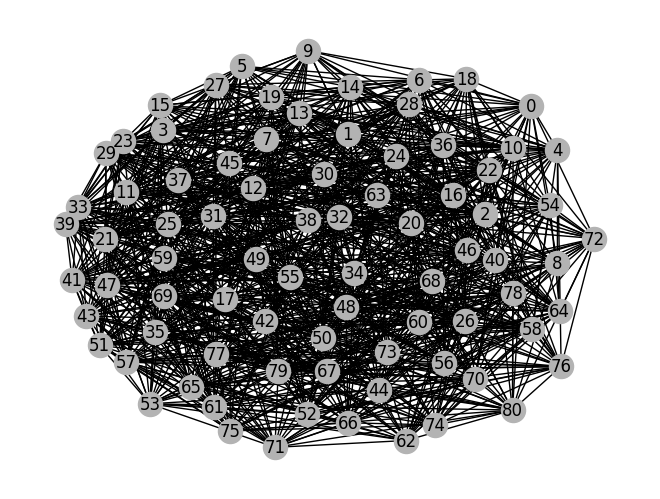

In [21]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [22]:
#creo classe della mia GNN


class GraphSAGE(nn.Module):
    """
    Basic GraphConv-based GNN class object. Constructs the model architecture upon
    initialization. Defines a forward step to include relevant parameters - in this
    case, just dropout.
    """
                            #self é la sua roba, g é torchgeom_graph
    def __init__(self, g, in_feats, hidden_size, num_classes, dropout):   #le in_feats diventano dim_embedding, hidden size e num_classes é da hypers
        """
        Initialize the model object. Establishes model architecture and relevant hypers (`dropout`, `num_classes`, `agg_type`)

        :param g: Input graph object
        :type g: Data of torch geometric
        :param in_feats: Size (number of nodes) of input layer
        :type in_feats: int
        :param hidden_size: Size of hidden layer
        :type hidden_size: int
        :param num_classes: Size of output layer (one node per class)
        :type num_classes: int
        :param dropout: Dropout fraction, between two convolutional layers
        :type dropout: float
        """

        super(GraphSAGE, self).__init__()
        self.g = g
        self.conv1 = SAGEConv(in_feats, hidden_size)
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = SAGEConv(hidden_size, num_classes)

    def forward(self, g):
        """
        Define forward step of netowrk. In this example, pass inputs through convolution, apply relu
        and dropout, then pass through second convolution.

        :param features: Input node representations
        :type features: torch.tensor
        :return: Final layer representation, pre-activation (i.e. class logits)
        :rtype: torch.tensor"""

        x, edge_index = g.x, g.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [23]:
print(torchgeom_graph)

Data(edge_index=[2, 2112], num_nodes=81)


In [24]:
dim_embedding = hypers['dim_embedding']
hidden_dim = hypers['hidden_dim']
dropout = hypers['dropout']
number_classes = hypers['number_classes']
agg_type = hypers['layer_agg_type'] or 'mean'
model=hypers['model']
print(model)

SAGEConv


In [25]:
print(hidden_dim)

16


In [26]:
embed = nn.Embedding(torchgeom_graph.num_nodes, dim_embedding)    #sto creando matrice  #sarebbero le in_feat ==  dim_embedding, creo #copie di valori dei nodi pari a dim_embedding
embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
print(embed)

Embedding(81, 109)


In [27]:
data = Data(x=embed.weight, edge_index=torchgeom_graph.edge_index)
print(data.x.shape)
print(data.edge_index.shape)   #OK

torch.Size([81, 109])
torch.Size([2, 2112])


In [28]:
# instantiate the GNN
print(f'Building {model} model...')
if model=='SAGEConv':
  net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)      #sarebbe la mia classe che devo definire (fatto sopra)
  #def cosi net = GraphSAGE(in_channels=dim_embedding, hidden_channels=dim_embedding, out_channels=num_classes)
elif model == 'GNN':
  #net = GCN(Conv)
  print('ci va l altra')

print(net)

Building SAGEConv model...
GraphSAGE(
  (conv1): SAGEConv(109, 16, aggr=mean)
  (relu): ReLU()
  (dropout): Dropout(p=0.3257, inplace=False)
  (conv2): SAGEConv(16, 10, aggr=mean)
)


In [29]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

# Get adjacency matrix for use in calculations
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)

# See minimal_utils.py for description. Constructs GNN and optimizer objects from given hypers.
# Initializes embedding layer to use as initial model input
#net, embed, optimizer gia def

In [30]:
print(adj_.shape)
print(adj_)

torch.Size([81, 81])
tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.]])


In [31]:
# set up Adam optimizer
params = chain(net.parameters(), embed.parameters())

print('Building ADAM-W optimizer...')
optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)            #weight_decay = decadimento esponenziale che contiene overfitting
#scheduler= torch.optim.lr_scheduler.StepLR(optimizer,step_size=100000,gamma=1.5)    #AGGIUNTA IL 18/10 #step_size, ogni quante epoche il lr diminuisce del 10%(gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500)


print(optimizer)

Building ADAM-W optimizer...
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.02636
    maximize: False
    weight_decay: 0.01
)


In [32]:
# helper function for graph-coloring loss
def loss_func_mod(probs, adj_tensor):
    """
    Function to compute cost value based on soft assignments (probabilities)

    :param probs: Probability vector, of each node belonging to each class
    :type probs: torch.tensor
    :param adj_tensor: Adjacency matrix, containing internode weights
    :type adj_tensor: torch.tensor
    :return: Loss, given the current soft assignments (probabilities)
    :rtype: float
    """

    # Multiply probability vectors, then filter via elementwise application of adjacency matrix.
    #  Divide by 2 to adjust for symmetry about the diagonal
    loss_ = torch.mul(adj_tensor, (probs @ probs.T)).sum() / 2

    return loss_      #sarebbe la mia energia di potts

# helper function for custom loss according to Q matrix
def loss_func_color_hard(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph  --> da me cambiato con DiGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost_ = 0
    for (u, v) in nx_graph.edges:
        cost_ += 1*(coloring[u] == coloring[v])*(u != v)     #1 if the two nodes have the same color and are not the same node

    return cost_

In [33]:
print(nx_graph.edges)

[(0, 10), (0, 20), (0, 30), (0, 40), (0, 50), (0, 60), (0, 70), (0, 80), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 18), (0, 27), (0, 36), (0, 45), (0, 54), (0, 63), (0, 72), (1, 10), (1, 11), (1, 21), (1, 31), (1, 41), (1, 51), (1, 61), (1, 71), (1, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 19), (1, 28), (1, 37), (1, 46), (1, 55), (1, 64), (1, 73), (2, 10), (2, 20), (2, 12), (2, 22), (2, 32), (2, 42), (2, 52), (2, 62), (2, 18), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 11), (2, 29), (2, 38), (2, 47), (2, 56), (2, 65), (2, 74), (3, 30), (3, 13), (3, 23), (3, 33), (3, 43), (3, 53), (3, 11), (3, 19), (3, 27), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 12), (3, 21), (3, 39), (3, 48), (3, 57), (3, 66), (3, 75), (4, 20), (4, 40), (4, 14), (4, 24), (4, 34), (4, 44), (4, 12), (4, 28), (4, 36), (4, 5), (4, 6), (4, 7), (4, 8), (4, 13), (4, 22), (4, 31), (4, 49), (4, 58), (4, 67), (4, 76), (5, 50), (5, 15), (5, 25), (5, 35), (5, 1

In [34]:
print(nx_graph.number_of_edges())

1056


In [35]:
def trainCycle(seed=hypers['seed']):
  # Ensure RNG seeds are reset each training run
  #seed=hypers['seed']
  print(f'Start training(): Setting seed to {seed}')
  #seed=1
  set_seed(seed)
  number_epochs=int(5e4)
  patience=500
  tolerance=1e-3


  # Tracking
  best_cost = torch.tensor(float('Inf'))  # high initialization
  best_loss = torch.tensor(float('Inf'))
  best_coloring = None
  best_model = net.state_dict()

  # Early stopping to allow NN to train to near-completion
  prev_loss = 1.  # initial loss value (arbitrary)
  cnt = 0  # track number times early stopping is triggered
  #count_stessicolori=0


  #metto conto del tempo
  t_start = time()
  loss_vector_story=[]
  hard_cost_vector_story=[]

  count_stessicolori=0



  # Training logic
  for epoch in range(number_epochs):
      # get soft prob assignments
      logits = net(data)       #rispetto a prima net mi prende tutto il formato data

      # apply softmax for normalization
      probs = F.softmax(logits, dim=1)       #qua dovrebbe normalizzare
      #print('probs=',probs)
      #print(probs.shape)           #========esce 25x5 (sarebbero le 5 prob dei 5 colori per ogni nodo, poi devo prendere quella maggiore)

      # get cost value with POTTS cost function
      loss = loss_func_mod(probs, adj_)              #calcolo la loss con modello potts

      # get cost based on current hard class assignments
      # update cost if applicable
      coloring = torch.argmax(probs, dim=1)
      #print(coloring.shape)                             #questo é effettivamente il vettore dei colori di questa epoca (con 25 elementi che sono numeri da 0 a 4)
      cost_hard = loss_func_color_hard(coloring, nx_graph)           #nodi diversi ma collegati e dello stesso colore

      if cost_hard < best_cost:           #best_cost= il miglior cost_hard    #best_coloring=il coloring col miglior cost_hard
          best_loss = loss
          best_cost = cost_hard     #sarebbe sbaglio 'discreto'
          best_coloring = coloring
          best_model = net.state_dict()
          #save_model(net,save_model_path, best_cost, best_loss, epoch)
          #torch.save(net.state_dict(), 'SAGE_best_model_coloring_5X5.pth')                    #aggiunto stasera
          #print(f'Model saved with best_cost: {best_cost:.4f}  and best_loss(soft loss): {best_loss:.4f} at the epoch: {epoch}')             #aggiunto stasera

      # Early stopping check
      # If loss increases or change in loss is too small, trigger
      if (abs(loss - prev_loss) <= tolerance) | ((loss - prev_loss) > 0):
          cnt += 1
      else:
          cnt = 0

      #if (best_cost == cost_hard):
      #    count_stessicolori+=1
      #else:
      #    count_stessicolori=0

      # update loss tracking
      prev_loss = loss

      loss_vector_story.append(loss.item())               #mi dovrebbe dare la loss nelle epoche (ogni 1000)
      hard_cost_vector_story.append(cost_hard.item())

      if cnt >= patience:
          print(f'Stopping early on epoch {epoch}. Patience count: {cnt}')
          break

      #if count_stessicolori >= patience:
      #    optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-1)
      #    print()

      # run optimization with backpropagation
      optimizer.zero_grad()  # clear gradient for step
      loss.backward()  # calculate gradient through compute graph
      optimizer.step()  # take step, update weights
      #scheduler.step()

      # tracking: print intermediate loss at regular interval
      if epoch % 1000 == 0:
          print('Epoch %d | Soft Loss: %.5f' % (epoch, loss.item()))
          print('Epoch %d | Discrete Cost: %.2f' % (epoch, cost_hard.item()))

  # Print final loss
  print('Epoch %d | Final loss: %.5f' % (epoch, loss.item()))
  print('Epoch %d | Lowest discrete cost: %.2f' % (epoch, best_cost))

  # Final coloring
  final_loss = loss
  final_coloring = torch.argmax(probs, 1)
  print(f'Final coloring: {final_coloring}, soft loss: {final_loss}')
  print(f'Best coloring: {best_coloring}, soft loss: {best_loss}')

  #conto finale del tempo
  runtime_gnn = round(time() - t_start, 4)
  # report results
  print(f'GNN runtime: {runtime_gnn}s')

  return best_model, loss_vector_story, hard_cost_vector_story, best_coloring

In [36]:
net.to(TORCH_DEVICE)
data.to(TORCH_DEVICE) #non so quanto sia utile

Data(x=[81, 109], edge_index=[2, 2112])

In [37]:
_, loss_vector_story, hard_cost_vector_story, best_coloring = trainCycle()

Start training(): Setting seed to 0
Epoch 0 | Soft Loss: 118.00520
Epoch 0 | Discrete Cost: 475.00
Epoch 1000 | Soft Loss: 27.78836
Epoch 1000 | Discrete Cost: 28.00
Epoch 2000 | Soft Loss: 21.00000
Epoch 2000 | Discrete Cost: 21.00


KeyboardInterrupt: 

In [ ]:
loss_vector_story_array=np.array(loss_vector_story)
hard_cost_vector_story_array= np.array(hard_cost_vector_story)

print(loss_vector_story_array.shape)

In [ ]:
# Traccio il grafico della loss
from matplotlib import pyplot as plt
import math
#loss_vector_story_array= np.array(loss_vector_story)

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss durante l\'addestramento con lr:0.0001 e weight decay 0.01')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))
plt.legend()
plt.grid()
plt.show()

# Traccio il grafico della loss nelle prime 500 epoche

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.xlim(0,500)
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))              #prendo il massimo di questa lista(loss_vector_story) e lo rendo un numero
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Traccia il grafico della loss
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento con lr:0.0001 e weight decay 0.01')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.xlim(0,500)
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Visualize result
color_dict = {
    0: "blue",      # blu
    1: "orange",    # arancione
    2: "green",     # verde
    3: "red",       # rosso
    4: "purple",    # viola
    5: "brown",     # marrone
    6: "pink",      # rosa
    7: "gray",      # grigio
    8: "olive",     # giallo oliva
    9: "cyan",      # ciano
}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

In [ ]:
#PROVO A FARMI PLOTTARE I LINK SBAGLIATI IN ROSSO

#color_dict = {0:'orange', 1:'lightblue', 2:'purple', 3:'red', 4:'lightgreen',5:'green',6:'yellow',7:'pink'}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
edge_color_map = ['red' if best_coloring[u] == best_coloring[v] else 'black' for u, v in nx_graph.edges()]

wrong_edges=[(u, v) for u, v in nx_graph.edges() if best_coloring[u] == best_coloring[v]]  # Archi rossi=archi sbagliati

nx.draw(nx_graph, pos, with_labels=False, node_color=color_map,edge_color=edge_color_map)
nx.draw_networkx_edges(nx_graph, pos, edgelist=wrong_edges, edge_color='red')      #me le plotta sopra le altre

In [39]:
#definisco funzione che mi calcola errore come:
#numero di edges sbagliate con potts/num link
def err_gen(coloring):
  num_link = torchgeom_graph.edge_index.shape[1]
  cost_discreto = loss_func_color_hard(coloring, nx_graph)
  eps=cost_discreto/num_link               #dovrebbe considerare che il grafo é indiretto sia nel costo discreto che nel numero dei link

  return num_link, cost_discreto, eps

In [ ]:
err = err_gen(best_coloring)
print(f'Numero di link: {err[0]}   Hard cost: {err[1]}')
print(f'errore = {err[2] * 100:.3f}.%')

In [40]:
from matplotlib import pyplot as plt
import math

Start training(): Setting seed to 1
Epoch 0 | Soft Loss: 153.06166
Epoch 0 | Discrete Cost: 267.00
Epoch 1000 | Soft Loss: 58.77649
Epoch 1000 | Discrete Cost: 46.00
Epoch 2000 | Soft Loss: 53.87128
Epoch 2000 | Discrete Cost: 42.00
Epoch 3000 | Soft Loss: 51.21717
Epoch 3000 | Discrete Cost: 41.00
Epoch 4000 | Soft Loss: 44.59960
Epoch 4000 | Discrete Cost: 37.00
Epoch 5000 | Soft Loss: 51.62638
Epoch 5000 | Discrete Cost: 53.00
Epoch 6000 | Soft Loss: 31.19606
Epoch 6000 | Discrete Cost: 31.00
Epoch 7000 | Soft Loss: 35.94169
Epoch 7000 | Discrete Cost: 25.00
Epoch 8000 | Soft Loss: 44.70324
Epoch 8000 | Discrete Cost: 33.00
Epoch 9000 | Soft Loss: 37.55095
Epoch 9000 | Discrete Cost: 34.00
Epoch 10000 | Soft Loss: 35.99013
Epoch 10000 | Discrete Cost: 30.00
Epoch 11000 | Soft Loss: 32.55140
Epoch 11000 | Discrete Cost: 25.00
Epoch 12000 | Soft Loss: 33.04958
Epoch 12000 | Discrete Cost: 30.00
Epoch 13000 | Soft Loss: 34.56724
Epoch 13000 | Discrete Cost: 32.00
Epoch 14000 | Soft Los

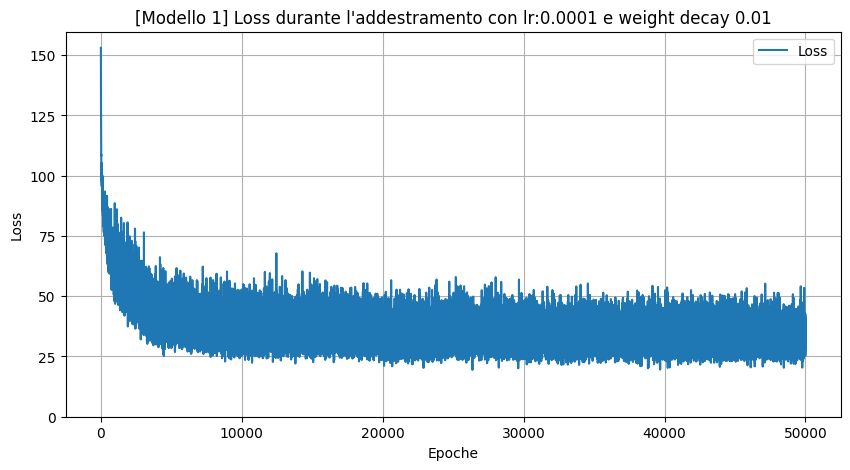

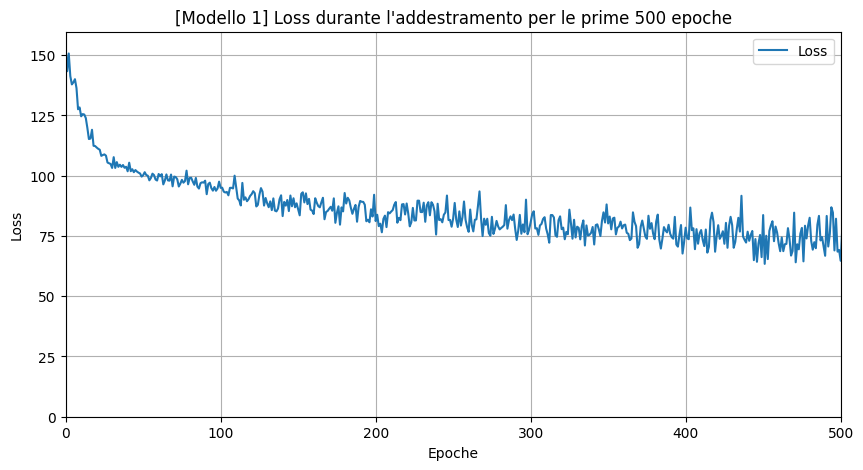

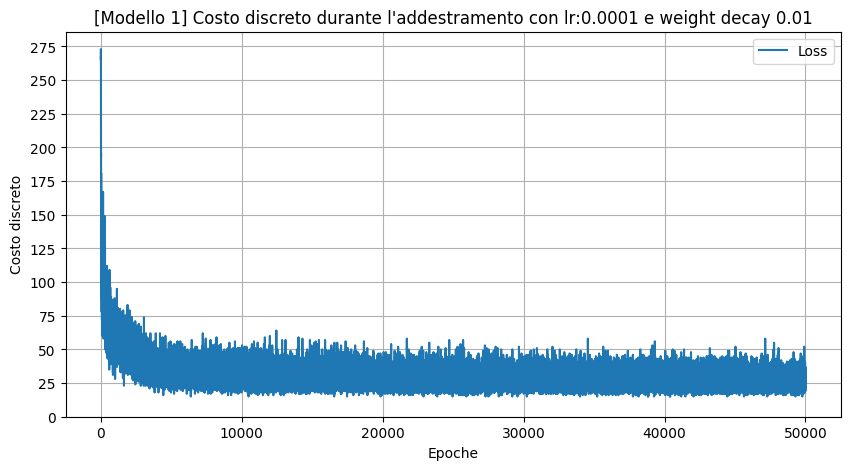

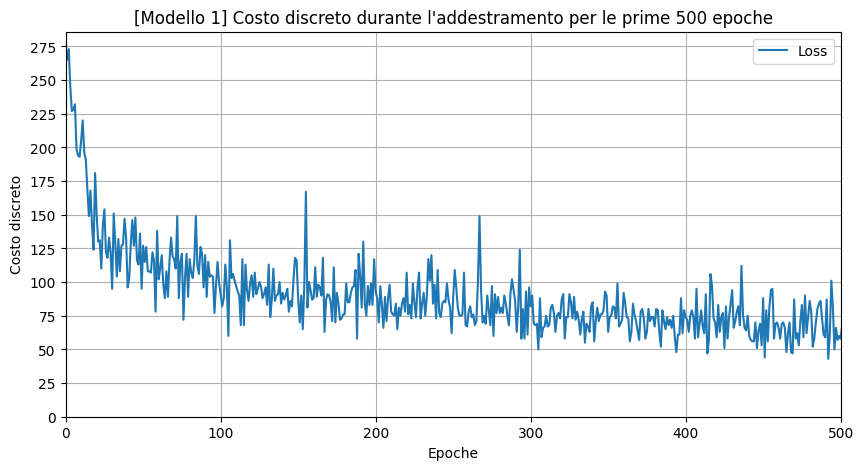

Start training(): Setting seed to 2
Epoch 0 | Soft Loss: 128.38568
Epoch 0 | Discrete Cost: 129.00
Epoch 1000 | Soft Loss: 67.61629
Epoch 1000 | Discrete Cost: 54.00
Epoch 2000 | Soft Loss: 51.27085
Epoch 2000 | Discrete Cost: 42.00
Epoch 3000 | Soft Loss: 49.88546
Epoch 3000 | Discrete Cost: 44.00
Epoch 4000 | Soft Loss: 49.75974
Epoch 4000 | Discrete Cost: 45.00
Epoch 5000 | Soft Loss: 59.73661
Epoch 5000 | Discrete Cost: 57.00
Epoch 6000 | Soft Loss: 43.05175
Epoch 6000 | Discrete Cost: 37.00
Epoch 7000 | Soft Loss: 42.49507
Epoch 7000 | Discrete Cost: 35.00
Epoch 8000 | Soft Loss: 44.47157
Epoch 8000 | Discrete Cost: 36.00
Epoch 9000 | Soft Loss: 36.48233
Epoch 9000 | Discrete Cost: 32.00
Epoch 10000 | Soft Loss: 43.05535
Epoch 10000 | Discrete Cost: 33.00
Epoch 11000 | Soft Loss: 43.78115
Epoch 11000 | Discrete Cost: 39.00
Epoch 12000 | Soft Loss: 43.18292
Epoch 12000 | Discrete Cost: 39.00
Epoch 13000 | Soft Loss: 48.38506
Epoch 13000 | Discrete Cost: 49.00
Epoch 14000 | Soft Los

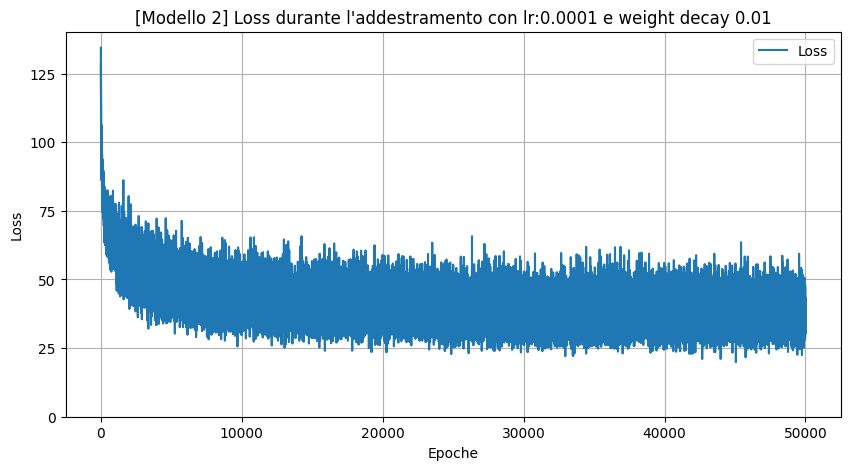

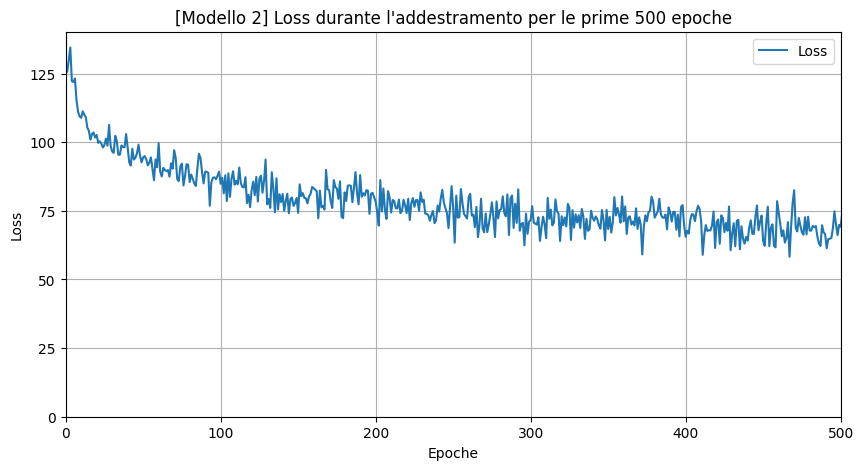

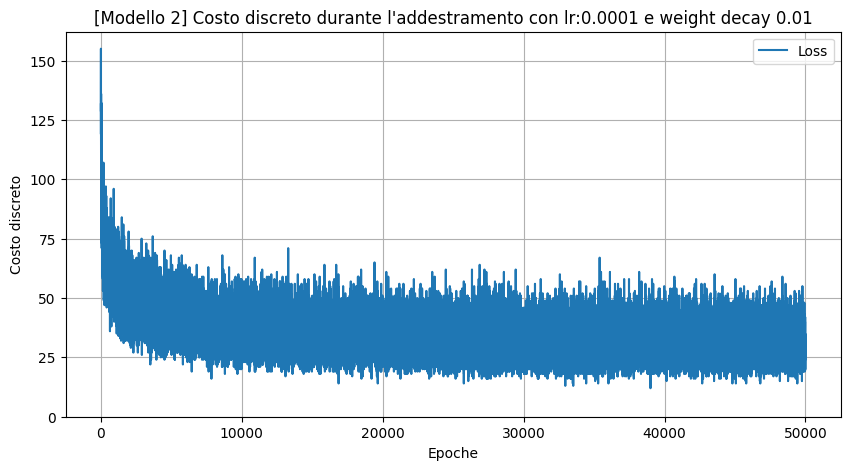

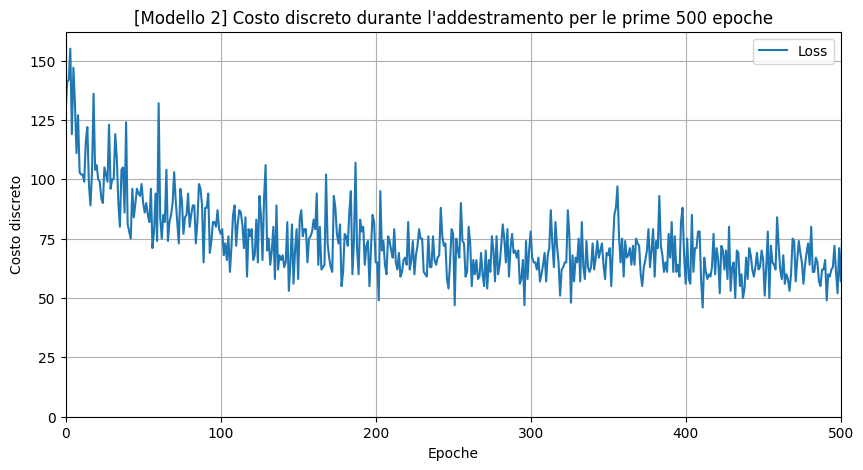

Start training(): Setting seed to 3
Epoch 0 | Soft Loss: 179.91547
Epoch 0 | Discrete Cost: 242.00
Epoch 1000 | Soft Loss: 54.96879
Epoch 1000 | Discrete Cost: 51.00
Epoch 2000 | Soft Loss: 47.71294
Epoch 2000 | Discrete Cost: 39.00
Epoch 3000 | Soft Loss: 46.47763
Epoch 3000 | Discrete Cost: 36.00
Epoch 4000 | Soft Loss: 48.73747
Epoch 4000 | Discrete Cost: 47.00
Epoch 5000 | Soft Loss: 36.90378
Epoch 5000 | Discrete Cost: 32.00
Epoch 6000 | Soft Loss: 43.93401
Epoch 6000 | Discrete Cost: 42.00
Epoch 7000 | Soft Loss: 50.04242
Epoch 7000 | Discrete Cost: 46.00
Epoch 8000 | Soft Loss: 38.97503
Epoch 8000 | Discrete Cost: 35.00
Epoch 9000 | Soft Loss: 32.63290
Epoch 9000 | Discrete Cost: 24.00
Epoch 10000 | Soft Loss: 32.62575
Epoch 10000 | Discrete Cost: 28.00
Epoch 11000 | Soft Loss: 42.92998
Epoch 11000 | Discrete Cost: 40.00
Epoch 12000 | Soft Loss: 33.05435
Epoch 12000 | Discrete Cost: 25.00
Epoch 13000 | Soft Loss: 31.40571
Epoch 13000 | Discrete Cost: 27.00
Epoch 14000 | Soft Los

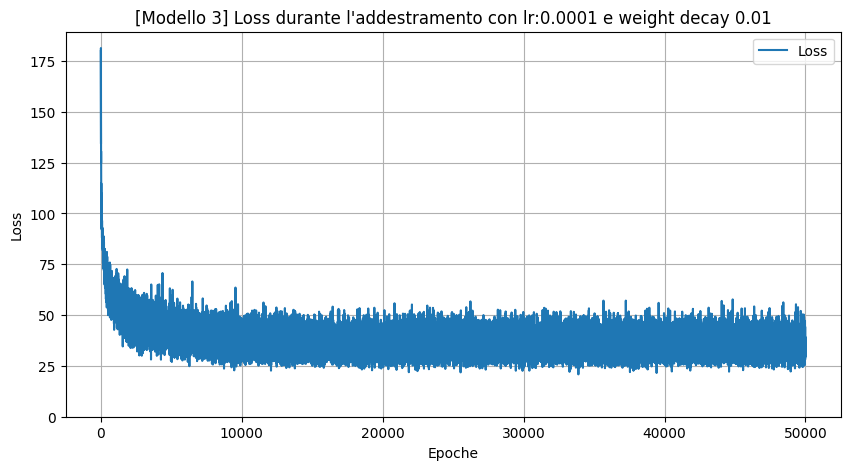

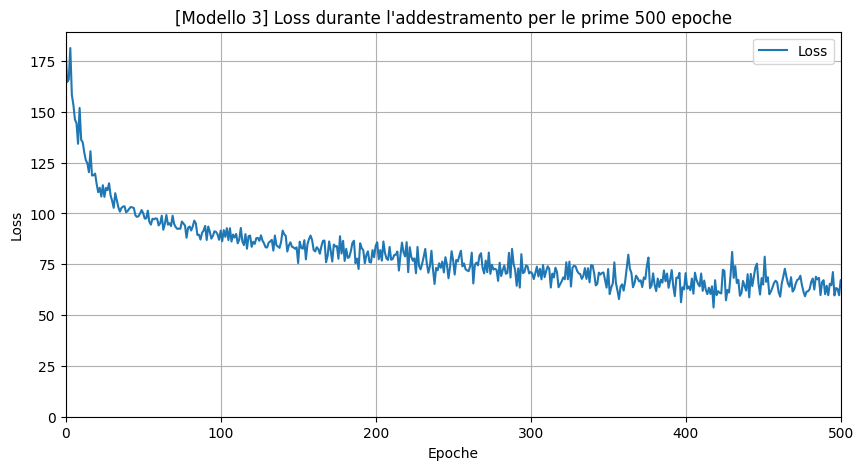

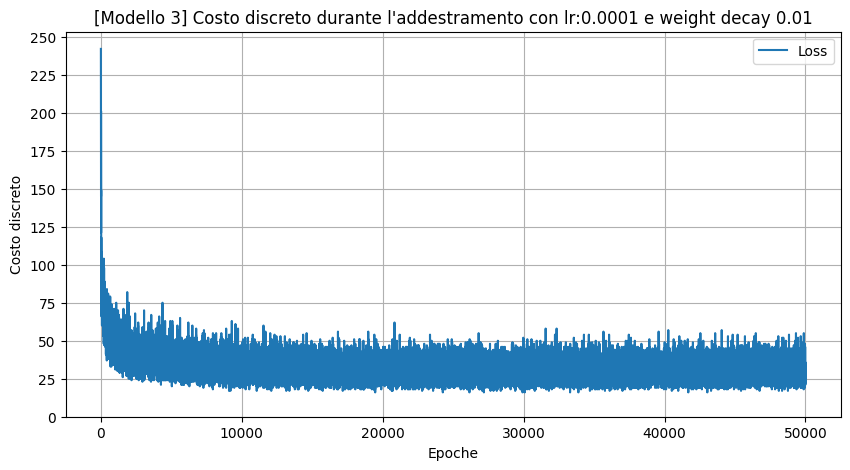

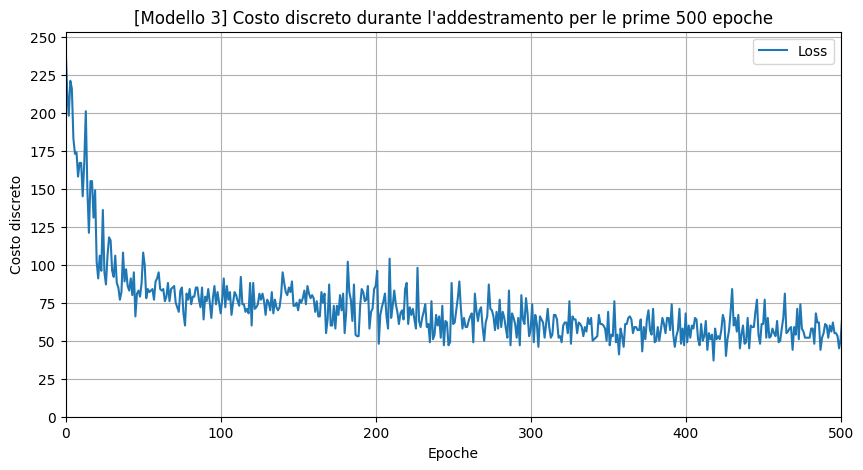

Start training(): Setting seed to 4
Epoch 0 | Soft Loss: 417.00525
Epoch 0 | Discrete Cost: 715.00
Epoch 1000 | Soft Loss: 85.21674
Epoch 1000 | Discrete Cost: 99.00
Epoch 2000 | Soft Loss: 80.01152
Epoch 2000 | Discrete Cost: 76.00
Epoch 3000 | Soft Loss: 83.34621
Epoch 3000 | Discrete Cost: 92.00
Epoch 4000 | Soft Loss: 68.82880
Epoch 4000 | Discrete Cost: 67.00
Epoch 5000 | Soft Loss: 66.64668
Epoch 5000 | Discrete Cost: 60.00
Epoch 6000 | Soft Loss: 71.67160
Epoch 6000 | Discrete Cost: 69.00
Epoch 7000 | Soft Loss: 86.19351
Epoch 7000 | Discrete Cost: 103.00
Epoch 8000 | Soft Loss: 66.39771
Epoch 8000 | Discrete Cost: 54.00
Epoch 9000 | Soft Loss: 71.04776
Epoch 9000 | Discrete Cost: 70.00
Epoch 10000 | Soft Loss: 66.05243
Epoch 10000 | Discrete Cost: 63.00
Epoch 11000 | Soft Loss: 55.89666
Epoch 11000 | Discrete Cost: 44.00
Epoch 12000 | Soft Loss: 75.27931
Epoch 12000 | Discrete Cost: 64.00
Epoch 13000 | Soft Loss: 68.00315
Epoch 13000 | Discrete Cost: 53.00
Epoch 14000 | Soft Lo

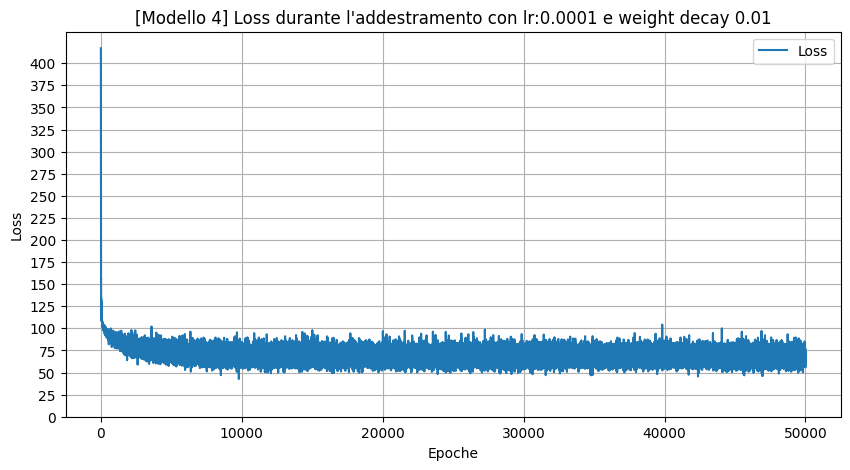

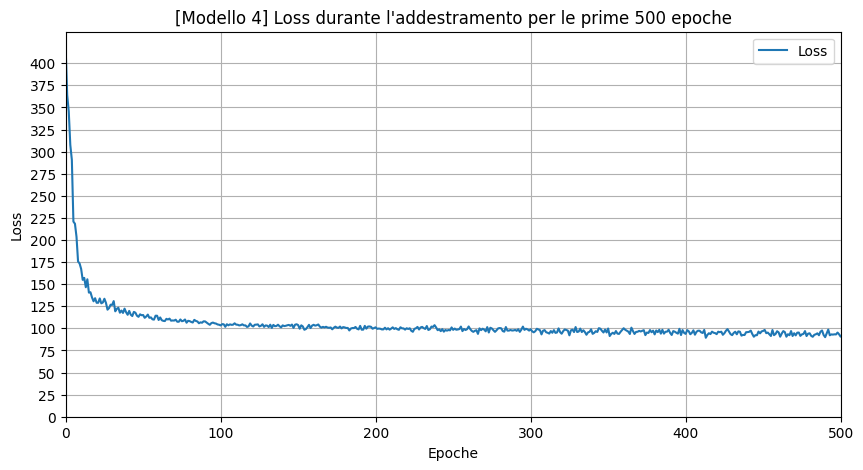

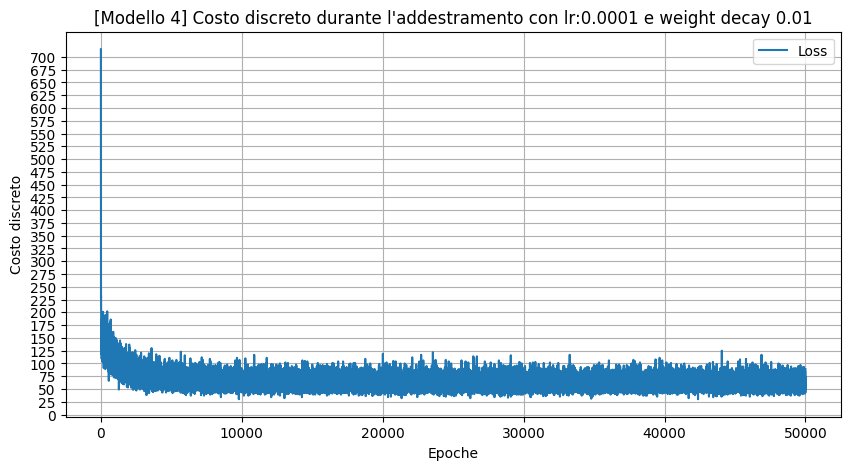

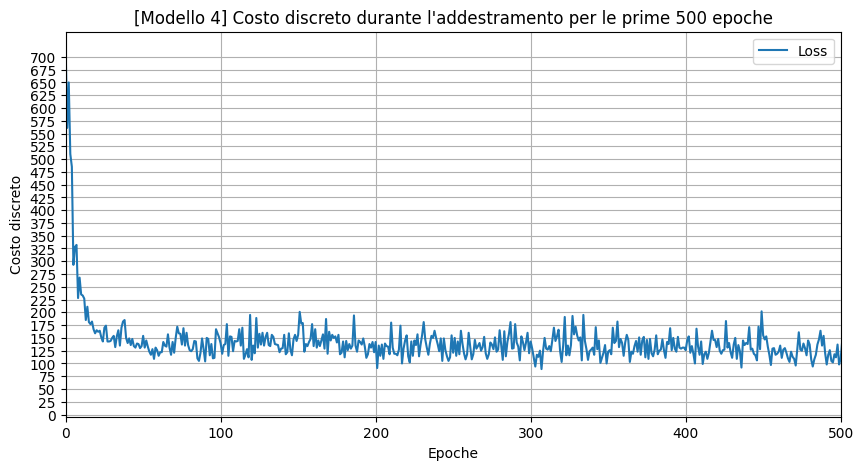

Start training(): Setting seed to 5
Epoch 0 | Soft Loss: 156.39680
Epoch 0 | Discrete Cost: 239.00
Epoch 1000 | Soft Loss: 57.11561
Epoch 1000 | Discrete Cost: 45.00
Epoch 2000 | Soft Loss: 52.22049
Epoch 2000 | Discrete Cost: 41.00
Epoch 3000 | Soft Loss: 40.26628
Epoch 3000 | Discrete Cost: 35.00
Epoch 4000 | Soft Loss: 42.30835
Epoch 4000 | Discrete Cost: 37.00
Epoch 5000 | Soft Loss: 46.21045
Epoch 5000 | Discrete Cost: 39.00
Epoch 6000 | Soft Loss: 35.33174
Epoch 6000 | Discrete Cost: 29.00
Epoch 7000 | Soft Loss: 41.80082
Epoch 7000 | Discrete Cost: 34.00
Epoch 8000 | Soft Loss: 46.10330
Epoch 8000 | Discrete Cost: 43.00
Epoch 9000 | Soft Loss: 39.13739
Epoch 9000 | Discrete Cost: 39.00
Epoch 10000 | Soft Loss: 39.49350
Epoch 10000 | Discrete Cost: 36.00
Epoch 11000 | Soft Loss: 42.54701
Epoch 11000 | Discrete Cost: 36.00
Epoch 12000 | Soft Loss: 38.44178
Epoch 12000 | Discrete Cost: 38.00
Epoch 13000 | Soft Loss: 38.96365
Epoch 13000 | Discrete Cost: 28.00
Epoch 14000 | Soft Los

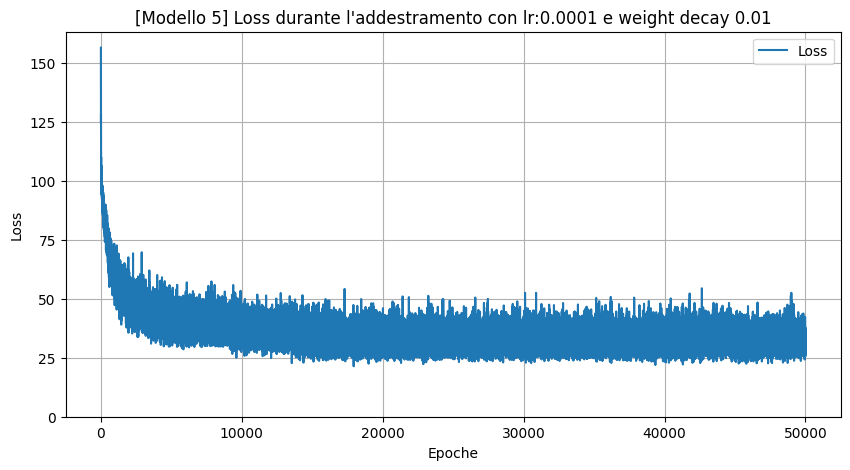

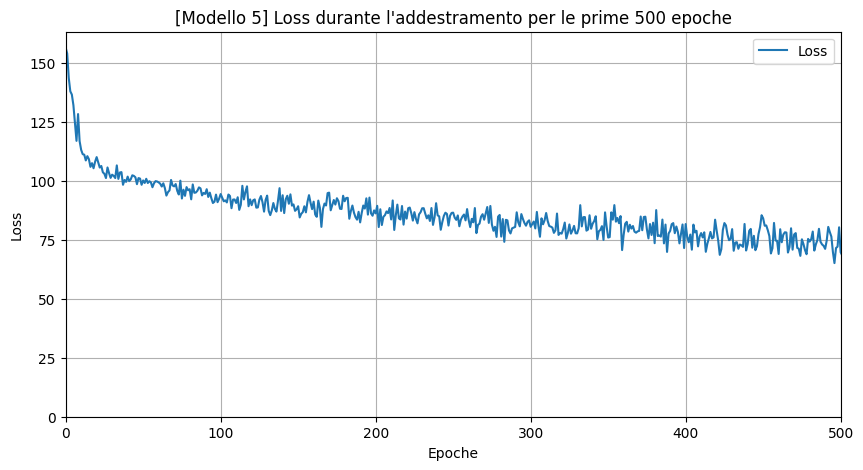

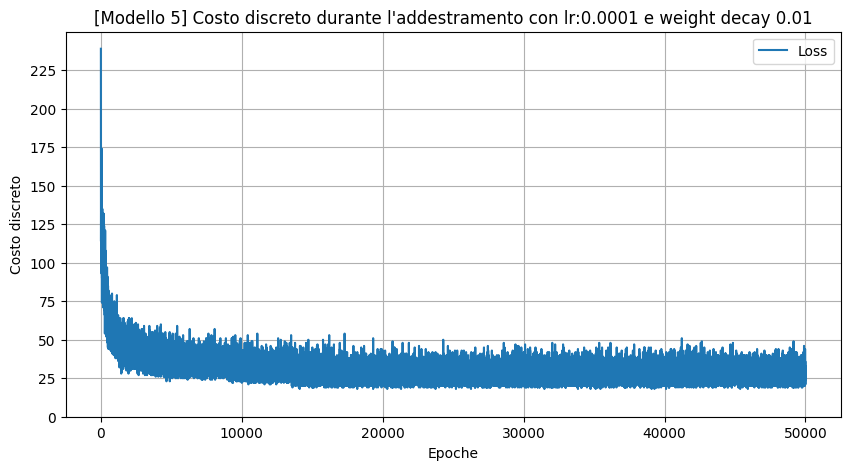

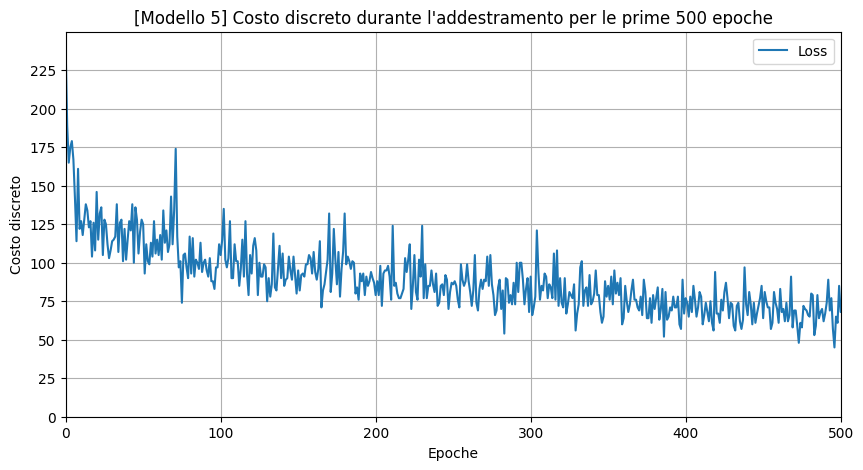

Start training(): Setting seed to 6
Epoch 0 | Soft Loss: 270.29163
Epoch 0 | Discrete Cost: 372.00
Epoch 1000 | Soft Loss: 60.84881
Epoch 1000 | Discrete Cost: 47.00
Epoch 2000 | Soft Loss: 56.89786
Epoch 2000 | Discrete Cost: 48.00
Epoch 3000 | Soft Loss: 53.90379
Epoch 3000 | Discrete Cost: 46.00
Epoch 4000 | Soft Loss: 44.61922
Epoch 4000 | Discrete Cost: 39.00
Epoch 5000 | Soft Loss: 46.75289
Epoch 5000 | Discrete Cost: 44.00
Epoch 6000 | Soft Loss: 39.92590
Epoch 6000 | Discrete Cost: 32.00
Epoch 7000 | Soft Loss: 46.71019
Epoch 7000 | Discrete Cost: 42.00
Epoch 8000 | Soft Loss: 51.16405
Epoch 8000 | Discrete Cost: 45.00
Epoch 9000 | Soft Loss: 53.47417
Epoch 9000 | Discrete Cost: 50.00
Epoch 10000 | Soft Loss: 45.92640
Epoch 10000 | Discrete Cost: 41.00
Epoch 11000 | Soft Loss: 48.46188
Epoch 11000 | Discrete Cost: 45.00
Epoch 12000 | Soft Loss: 41.51198
Epoch 12000 | Discrete Cost: 38.00
Epoch 13000 | Soft Loss: 48.44414
Epoch 13000 | Discrete Cost: 47.00
Epoch 14000 | Soft Los

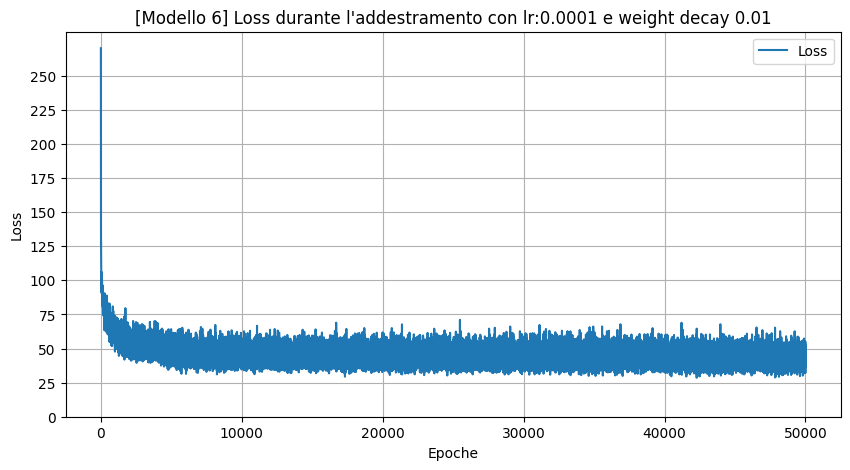

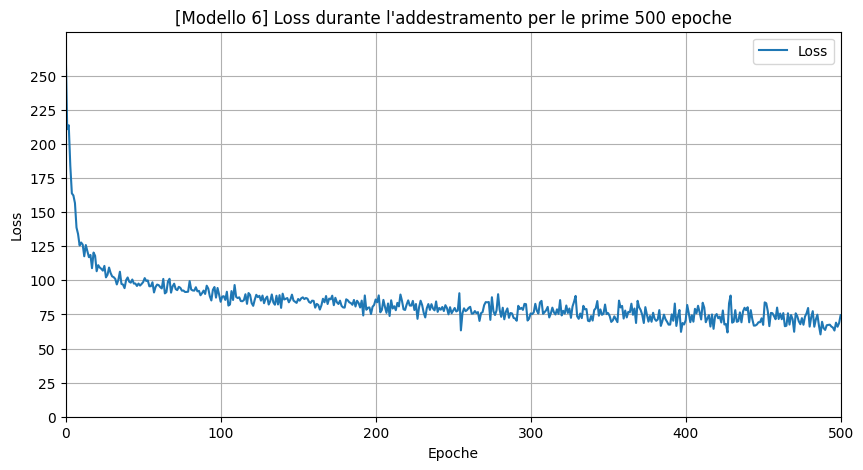

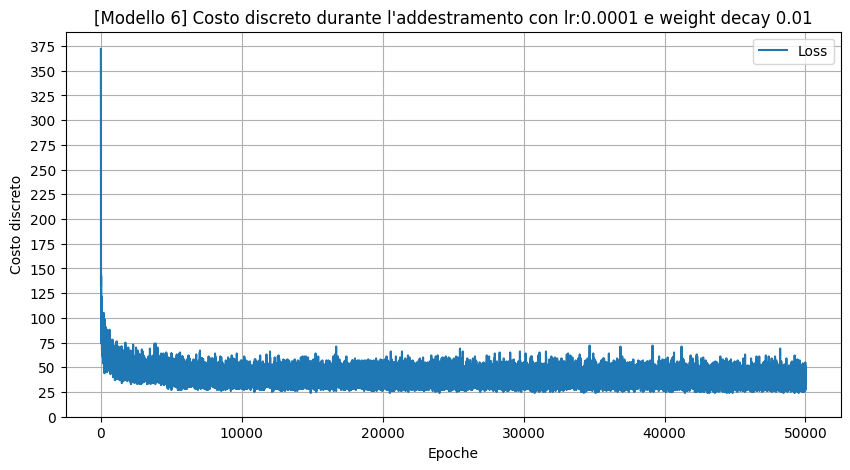

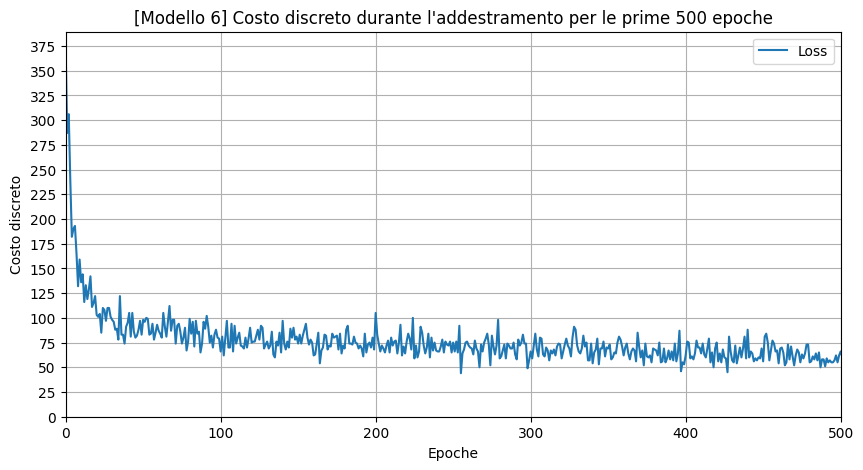

Start training(): Setting seed to 7
Epoch 0 | Soft Loss: 160.26920
Epoch 0 | Discrete Cost: 296.00
Epoch 1000 | Soft Loss: 76.47398
Epoch 1000 | Discrete Cost: 70.00
Epoch 2000 | Soft Loss: 69.49051
Epoch 2000 | Discrete Cost: 62.00
Epoch 3000 | Soft Loss: 53.92290
Epoch 3000 | Discrete Cost: 45.00
Epoch 4000 | Soft Loss: 51.82145
Epoch 4000 | Discrete Cost: 49.00
Epoch 5000 | Soft Loss: 50.82345
Epoch 5000 | Discrete Cost: 50.00
Epoch 6000 | Soft Loss: 41.71823
Epoch 6000 | Discrete Cost: 32.00
Epoch 7000 | Soft Loss: 48.02877
Epoch 7000 | Discrete Cost: 46.00
Epoch 8000 | Soft Loss: 47.79459
Epoch 8000 | Discrete Cost: 47.00
Epoch 9000 | Soft Loss: 40.46650
Epoch 9000 | Discrete Cost: 36.00
Epoch 10000 | Soft Loss: 47.46288
Epoch 10000 | Discrete Cost: 46.00
Epoch 11000 | Soft Loss: 51.04271
Epoch 11000 | Discrete Cost: 46.00
Epoch 12000 | Soft Loss: 44.95972
Epoch 12000 | Discrete Cost: 42.00
Epoch 13000 | Soft Loss: 46.16097
Epoch 13000 | Discrete Cost: 42.00
Epoch 14000 | Soft Los

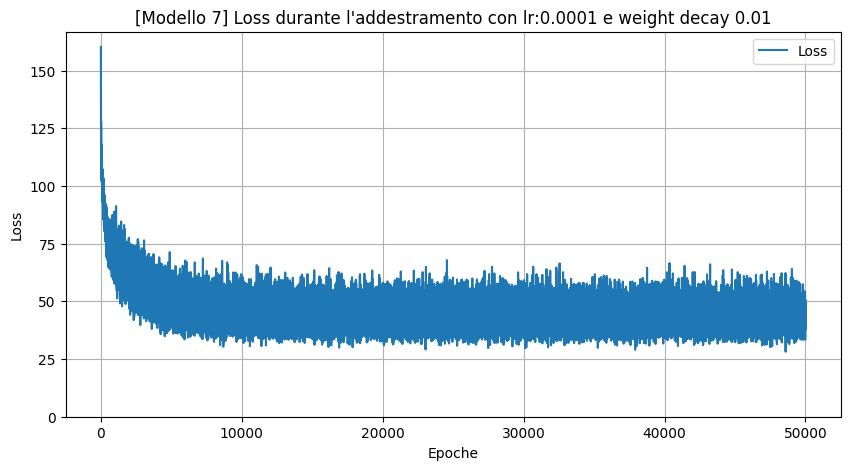

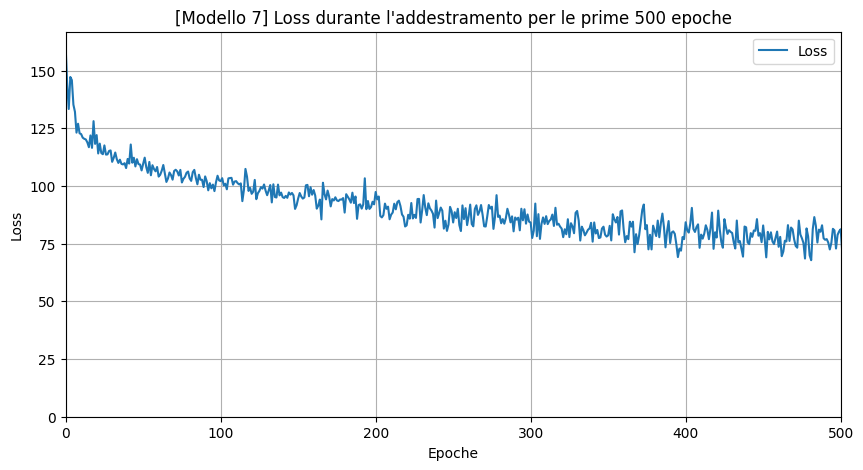

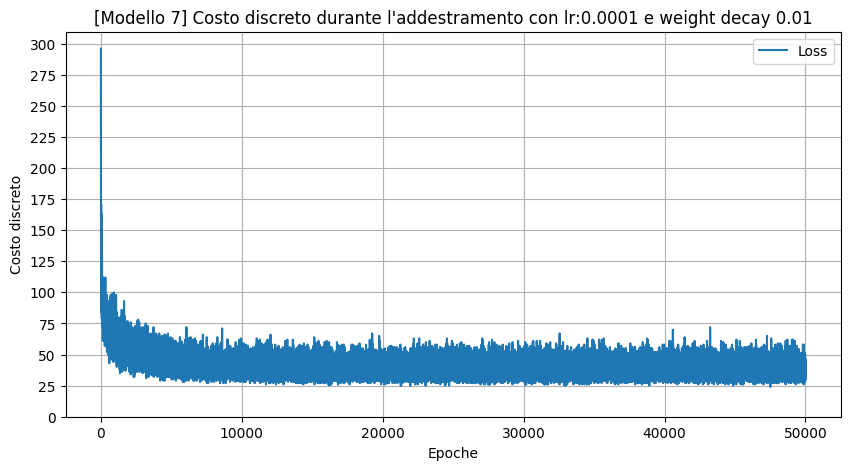

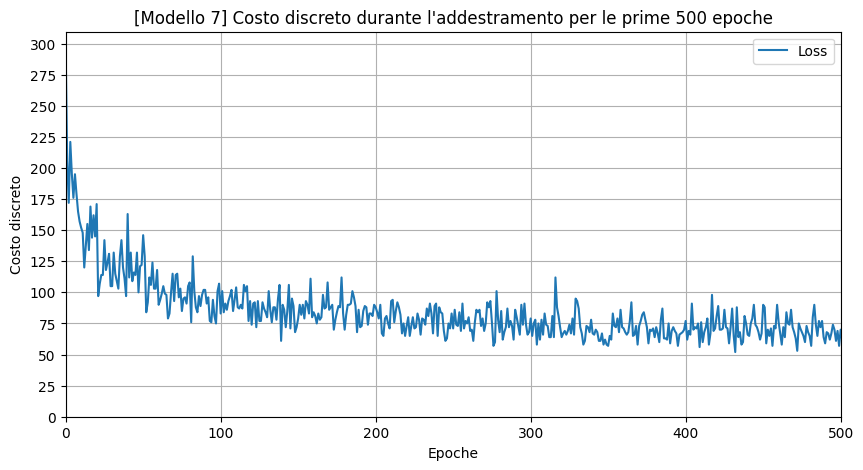

Start training(): Setting seed to 8
Epoch 0 | Soft Loss: 215.90703
Epoch 0 | Discrete Cost: 369.00
Epoch 1000 | Soft Loss: 69.31358
Epoch 1000 | Discrete Cost: 60.00
Epoch 2000 | Soft Loss: 59.67762
Epoch 2000 | Discrete Cost: 47.00
Epoch 3000 | Soft Loss: 56.88852
Epoch 3000 | Discrete Cost: 56.00
Epoch 4000 | Soft Loss: 43.52585
Epoch 4000 | Discrete Cost: 41.00
Epoch 5000 | Soft Loss: 39.25425
Epoch 5000 | Discrete Cost: 36.00
Epoch 6000 | Soft Loss: 41.81465
Epoch 6000 | Discrete Cost: 41.00
Epoch 7000 | Soft Loss: 37.86891
Epoch 7000 | Discrete Cost: 28.00
Epoch 8000 | Soft Loss: 48.07335
Epoch 8000 | Discrete Cost: 39.00
Epoch 9000 | Soft Loss: 33.76335
Epoch 9000 | Discrete Cost: 29.00
Epoch 10000 | Soft Loss: 37.86714
Epoch 10000 | Discrete Cost: 34.00
Epoch 11000 | Soft Loss: 30.03024
Epoch 11000 | Discrete Cost: 27.00
Epoch 12000 | Soft Loss: 29.60905
Epoch 12000 | Discrete Cost: 21.00
Epoch 13000 | Soft Loss: 37.25391
Epoch 13000 | Discrete Cost: 33.00
Epoch 14000 | Soft Los

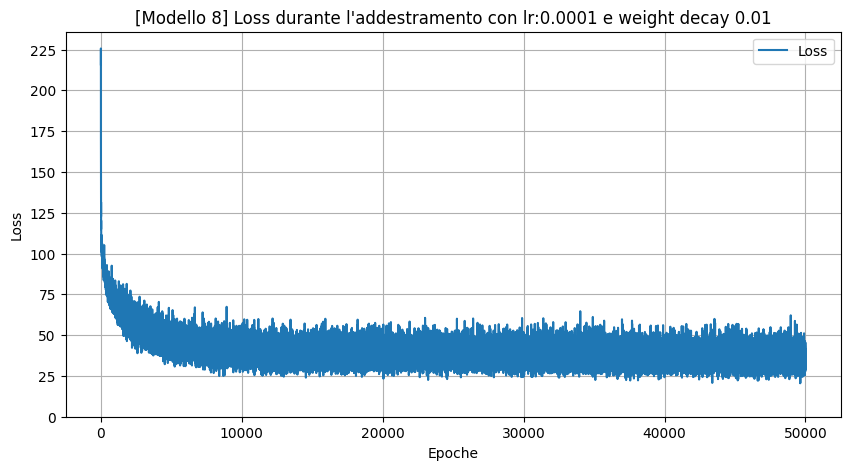

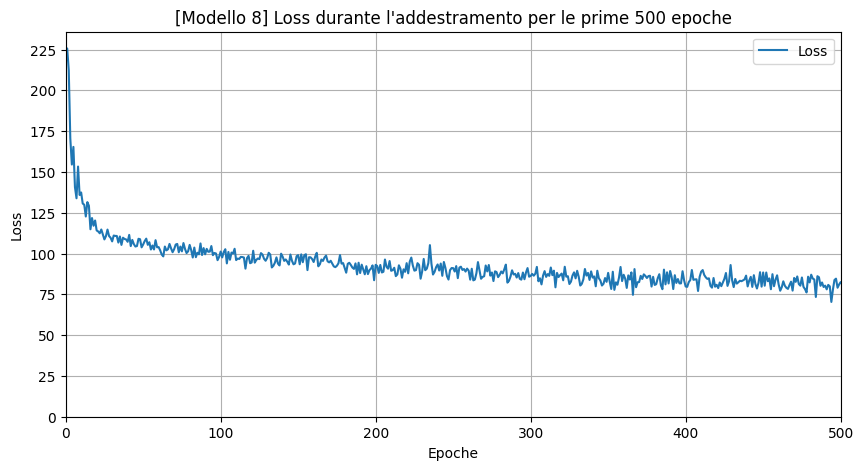

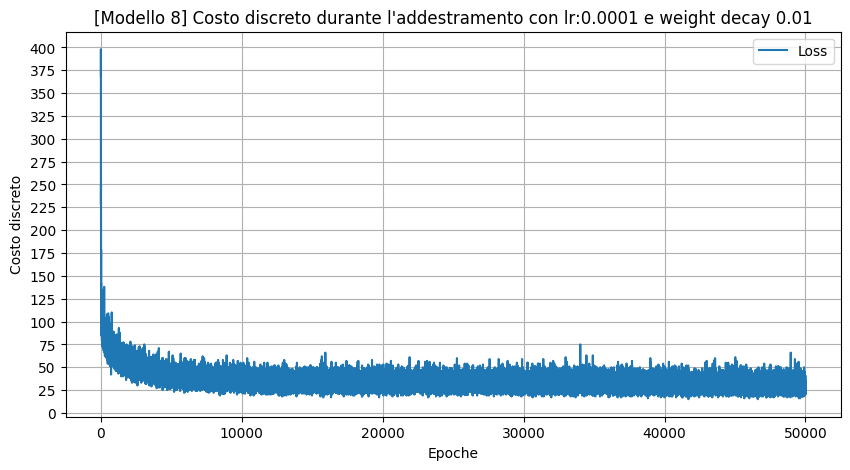

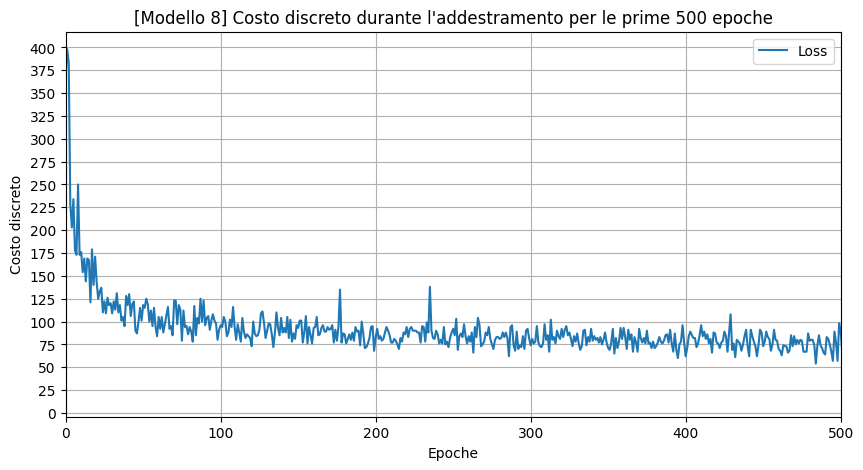

Start training(): Setting seed to 9
Epoch 0 | Soft Loss: 247.98741
Epoch 0 | Discrete Cost: 345.00
Epoch 1000 | Soft Loss: 63.09238
Epoch 1000 | Discrete Cost: 55.00
Epoch 2000 | Soft Loss: 51.25410
Epoch 2000 | Discrete Cost: 38.00
Epoch 3000 | Soft Loss: 43.66900
Epoch 3000 | Discrete Cost: 42.00
Epoch 4000 | Soft Loss: 47.18524
Epoch 4000 | Discrete Cost: 40.00
Epoch 5000 | Soft Loss: 36.63591
Epoch 5000 | Discrete Cost: 29.00
Epoch 6000 | Soft Loss: 32.68895
Epoch 6000 | Discrete Cost: 24.00
Epoch 7000 | Soft Loss: 33.58000
Epoch 7000 | Discrete Cost: 30.00
Epoch 8000 | Soft Loss: 33.76202
Epoch 8000 | Discrete Cost: 31.00
Epoch 9000 | Soft Loss: 34.23362
Epoch 9000 | Discrete Cost: 27.00
Epoch 10000 | Soft Loss: 34.50479
Epoch 10000 | Discrete Cost: 27.00
Epoch 11000 | Soft Loss: 43.03056
Epoch 11000 | Discrete Cost: 36.00
Epoch 12000 | Soft Loss: 42.99771
Epoch 12000 | Discrete Cost: 39.00
Epoch 13000 | Soft Loss: 34.55045
Epoch 13000 | Discrete Cost: 30.00
Epoch 14000 | Soft Los

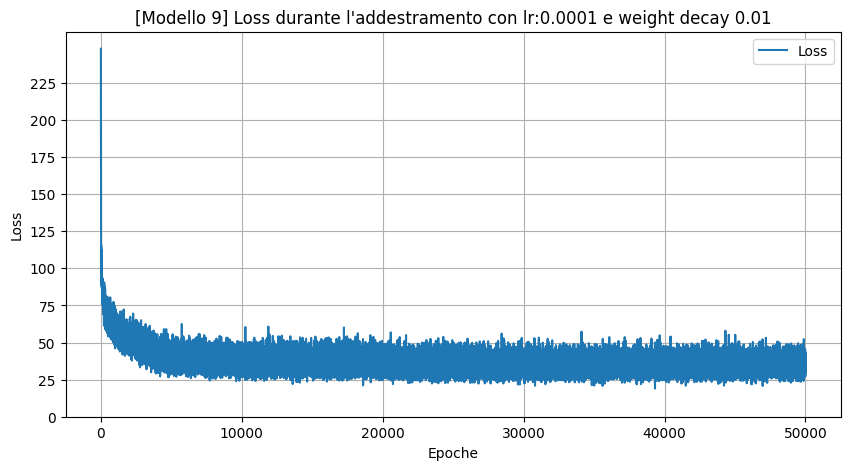

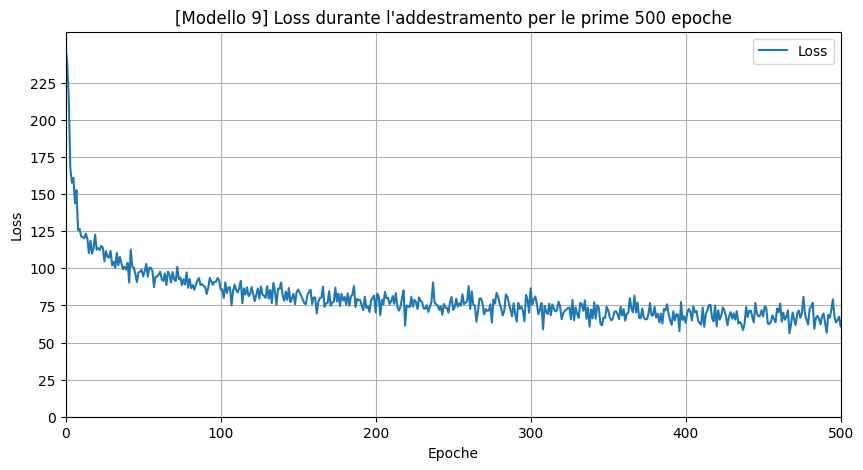

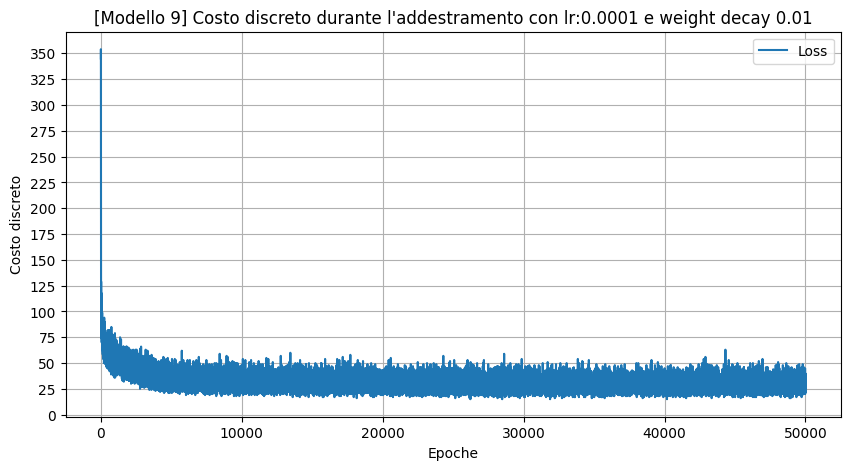

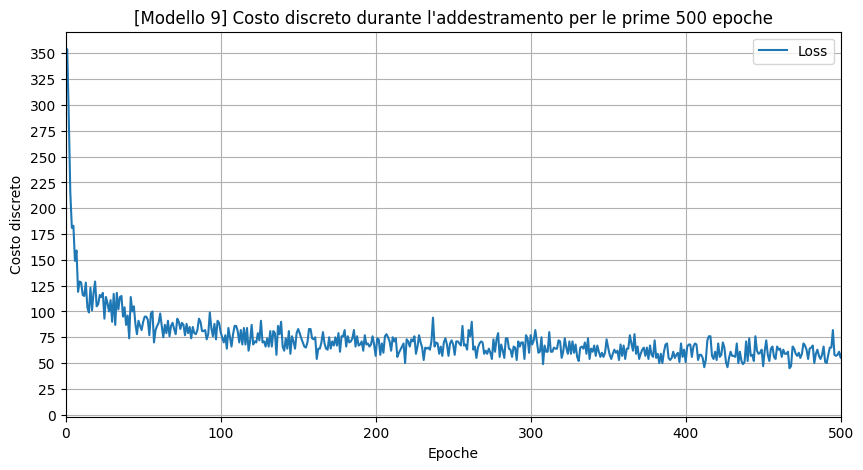

In [43]:
## Addestro più reti

#loss_collection = []
#cost_collection = []
err_collection = []

NUM_MODELLI = 10

for j in range(1,NUM_MODELLI):
    net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)
    net.to(TORCH_DEVICE)
    model, loss_vector_story, hard_cost_vector_story, best_coloring = trainCycle(j)
    #loss_collection.append(loss_vector_story)
    #cost_collection.append(hard_cost_vector_story)
    model_path = 'SAGE_best_model_coloring_9X9_Network_{j}.pth'
    torch.save(model, model_path)

    err_collection.append(err_gen(best_coloring))

    loss_vector_story_array=np.array(loss_vector_story)
    hard_cost_vector_story_array= np.array(hard_cost_vector_story)

    plt.figure(figsize=(10, 5))
    plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
    plt.title(f'[Modello {j}] Loss durante l\'addestramento con lr:0.0001 e weight decay 0.01')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))
    plt.legend()
    plt.grid()
    plt.show()

    # Traccio il grafico della loss nelle prime 500 epoche

    plt.figure(figsize=(10, 5))
    plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
    plt.title(f'[Modello {j}] Loss durante l\'addestramento per le prime 500 epoche')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.xlim(0,500)
    plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))              #prendo il massimo di questa lista(loss_vector_story) e lo rendo un numero
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
    plt.title(f'[Modello {j}] Costo discreto durante l\'addestramento con lr:0.0001 e weight decay 0.01')
    plt.xlabel('Epoche')
    plt.ylabel('Costo discreto')
    plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
    plt.title(f'[Modello {j}] Costo discreto durante l\'addestramento per le prime 500 epoche')
    plt.xlabel('Epoche')
    plt.ylabel('Costo discreto')
    plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
    plt.xlim(0,500)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for (j, err) in enumerate(err_collection):
  print(f'[{j}] Numero di link: {err[0]}   Hard cost: {err[1]}')
  print(f'[{j}] errore = {err[2] * 100:.3f}.%')

In [ ]:
for (j, story) in enumerate(loss_collection):
  # Traccio il grafico della loss
  from matplotlib import pyplot as plt
  import math
  #loss_vector_story_array= np.array(loss_vector_story)

  plt.figure(figsize=(10, 5))
  plt.plot(range((story.shape[0])), story, label='Loss')
  plt.title(f'[{j}] Loss durante l\'addestramento con lr:0.0001 e weight decay 0.01')
  plt.xlabel('Epoche')
  plt.ylabel('Loss')
  plt.yticks(range(0, math.floor(max(story)) + 1, 10))
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
for (j, story) in enumerate(cost_collection):
  # Traccia il grafico della loss
  plt.figure(figsize=(10, 5))
  plt.plot(range((story.shape[0])), story, label='Loss')
  plt.title(f'[{j}] Costo discreto durante l\'addestramento con lr:0.0001 e weight decay 0.01')
  plt.xlabel('Epoche')
  plt.ylabel('Costo discreto')
  plt.yticks(range(0, max(story) + 10, 10))
  plt.legend()
  plt.grid()
  plt.show()